In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
def plot_dist(raw, filtered, title):
    for i in range(data.shape[1]):
        column_name = raw.columns[i]
        plt.plot(raw.iloc[:, i], color = 'orange', linestyle='dashed', label=column_name+"_raw")
        plt.plot(filtered.iloc[:, i], color='green', label=column_name+"_filtered")
    plt.title(title)
    plt.xlabel('time (s)')
    plt.ylabel('RSSI (dBm)')
    plt.show()  
    
def plot_rssi_to_dist(b, a, calc_distance):
    plt.title('RSSI vs. Distance w/ fit coefficients a='+str(a)+' and b='+str(b))
    r=np.arange(-100,40) # arbitrary RSSI
    plt.xlabel('distance (m)')
    plt.ylabel('RSSI (dB)')
    plt.plot(r, calc_distance(r))
    plt.show()

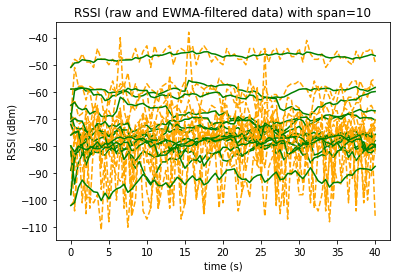

In [8]:
# import fitting data
filename = "raw/2020-09-20.csv"
data = pd.read_csv(filename, index_col=0)

# take EWMA with span=10 samples
span = 10
fwd_filtered = pd.DataFrame.ewm(data,span=span).mean() # take EWMA in fwd direction

# plot
plot_dist(data, fwd_filtered, 'RSSI (raw and EWMA-filtered data) with span='+str(span))

In [13]:
# import fitting data
filename     = "raw/2020-09-20.csv"
data_fitting = pd.read_csv(filename, index_col=0)

# Get distance and RSSI
# The mean of all the measurements are used as the
# RSSI at a particular distance
distance = np.array(pd.to_numeric(data_fitting.columns))
rssi     = np.array(data_fitting.mean(axis=0))

# RSSI-Distance Curve Fitting

Here we derive the RSSI to distance equation by fitting the data obtained for each known distance between two BLE nodes.

It is assumed that there is a logarithmic relationship between RSSI and distance.

## Distance vs. RSSI Data

In [26]:
# distance-RSSI data
print('D [m]', '\t', 'RSSI')
for d, r in zip(distance, rssi):
    print(d, '\t', "%.3f" % r)

D [m] 	 RSSI
0.25 	 -46.765
0.5 	 -59.370
0.75 	 -62.198
1.0 	 -68.519
1.5 	 -73.296
2.0 	 -73.778
2.5 	 -76.790
3.0 	 -74.667
3.5 	 -82.617
4.0 	 -78.568
4.5 	 -82.173
5.0 	 -78.568
7.5 	 -78.889
10.0 	 -92.198


## Curve Fitting

We use numpy's `polyfit()` function to derive the curve relating distance and RSSI.



$ d_{meters} = 10^{(MP - RSSI)/(10N)} $

Taking the logarithm of both sides yield

$ log_{10}(d_{meters}) = (MP)/(10N) - (1/(10N))RSSI $

Which can be rewritten into

$ log_{10}(d_{meters}) = A + B * RSSI $

The form of the equation above can be plugged in directly inside `numpy.polyfit()` to get the coefficients:

In [70]:
# Curve Fitting
[B, A] = np.polyfit(rssi, np.log10(distance), 1)

# RSSI to Distance utility function
def calc_distance(rssi): return 10**(a + b*rssi)

# Distance to RSSI utility function
def calc_rssi(distance): return (np.log10(distance) - a) / b

## Plotting the raw data and the fitted curve

We will draw the obtained curve together with the fitting data in one plot.

Placing the RSSI on the y-axis and distance on the x-axis, we have:

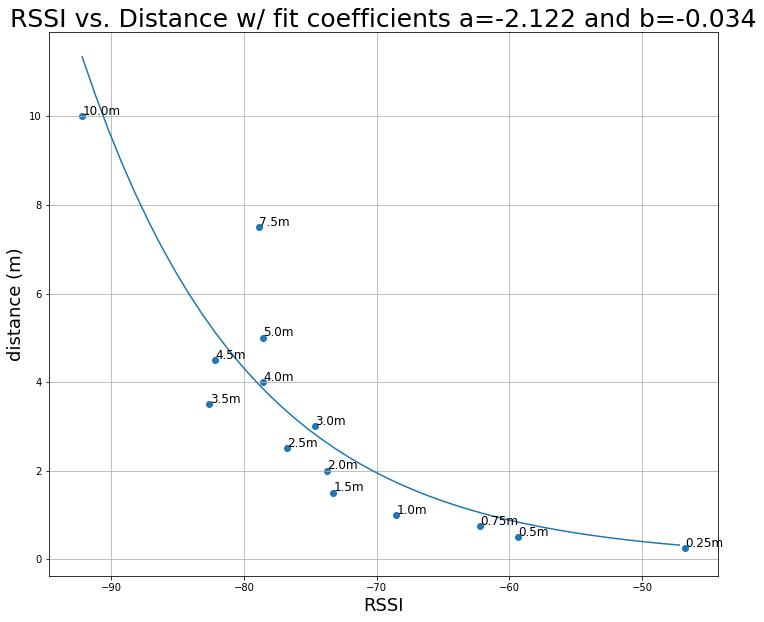

In [71]:
rssi_plot = np.arange(min(rssi), max(rssi))

plt.figure(figsize=(12,10))

# Plotting the fitted curve
plt.plot(rssi_plot, calc_distance(rssi_plot))

# Plotting the raw data, scatter-style
plt.scatter(rssi, distance)
for i, txt in enumerate(rssi):
    plt.text(rssi[i]+.03, distance[i]+.03, str(distance[i]) + 'm', fontsize=12)

plt.title('RSSI vs. Distance w/ fit coefficients a=' + '%0.3f' % a + ' and b=' + '%0.3f' % b, fontsize=25)
plt.xlabel('RSSI', fontsize=18)
plt.ylabel('distance (m)', fontsize=18)
plt.grid(b=True, which='major')
plt.show()

## Using the fitted curve to infer distance from future RSSI measurements

Eventually, we will use the fitted curve to infer distance from RSSI measurements.

### Inferring if two nodes are two (2) meters close (or less)

Say we want to determine whether two nodes are two meters close. We can use the expected RSSI at two meters from the fitted curve by using our utility function `calc_rssi()`. 

In [117]:
# Calculate the expected RSSI at two meters:

rssi_2m_threshold = calc_rssi(2)

print('Expected RSSI at 2 meters: %0.3f' % rssi_2m_threshold)

Expected RSSI at 2 meters: -70.325


### Naive rule-based approach of contact detection

We can use this value as our "contact" threshold - any RSSI measurements greater than this value means that the two nodes are at least two meters apart. On the other hand, anything lesser than this value means that our nodes are in "contact".

#### Testing the naive rule-based approach on our calibration data

Let us see how well the naive rule-based approach perform against our calibration data. For instance, we will use the RSSI measurements at a fixed node distance of 10 meters:

In [119]:
def plot_rssi_to_dist_against_fit(x, y):
    plt.figure(figsize=(8,6))
    plt.title('Distance vs. RSSI')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('distance (m)')
    plt.scatter(x, y)
    plt.plot(rssi_plot, calc_distance(rssi_plot))
    plt.plot([rssi_2m_threshold, rssi_2m_threshold], [0, 10], color='k', linestyle='-', linewidth=2)
    plt.show()

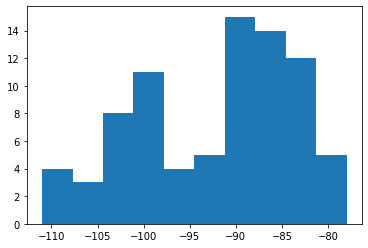

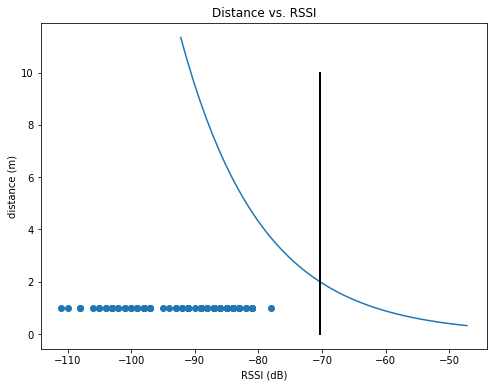

In [120]:
d = np.array(data_fitting['10.0'])

# Plotting histogram
plt.hist(d)

# Plotting against the fitted curve
plot_rssi_to_dist_against_fit(d, np.ones(d.shape[0]))

It's easy to see in the above graph that an object at a distance of 10 meters will not ever be judged as a false positive by our naive contact detector as "contact". However, let's try to grab the data from the 3 meter distance:

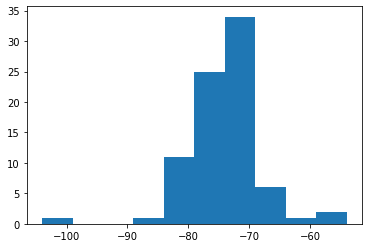

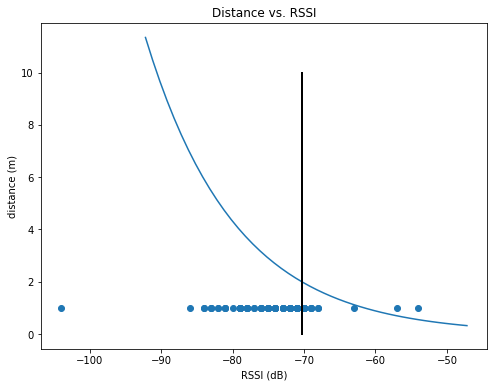

Number of false positives: 17  (20.99%)


In [130]:
rssi_at_3 = np.array(data_fitting['3.0'])

rssi_data     = rssi_at_3
rssi_data_len = rssi_data.shape[0]

# Plotting histogram
plt.hist(rssi_data)

# Plotting against the fitted curve
plot_rssi_to_dist_against_fit(rssi_data, np.ones(rssi_data_len))

# Count false positives
false_positive = np.sum(rssi_data > rssi_2m_threshold)
print('Number of false positives: %d ' % false_positive, '(%0.2f%%)' % (false_positive / float(rssi_data_len) * 100) )